In [4]:
import deodr
print(deodr.__version__)

0.2.1


In [5]:
import os
import glob
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_unet_collection import models
from tensorflow import keras
from keras_unet_collection.utils import dummy_loader
import cv2
import gc

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
# from drive.MyDrive.demo_cloth3d.cloth3d.DataReader.read2 import DataReader
# from drive.MyDrive.demo_cloth3d.cloth3d.DataReader.depth_render import Render
# from drive.MyDrive.demo_cloth3d.cloth3d.DataReader.util import intrinsic, extrinsic

import sys
sys.path.append('cloth3d')
sys.path.append('cloth3d/DataReader')
sys.path.append('cloth3d/DataReader/smpl')

from cloth3d.DataReader.read import DataReader
from cloth3d.DataReader.depth_render import Render
from cloth3d.DataReader.util import intrinsic, extrinsic

# Path to data
SRC = 'cloth3d++_subset'
print('SRC:', SRC)


SRC: cloth3d++_subset


In [22]:
def parse_obj_file(file_path):
    vertices = []
    faces = []

    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'v':
                vertices.append([float(parts[1]), float(parts[2]), float(parts[3])])
            elif parts[0] == 'f':
                face = []
                for part in parts[1:]:
                    indices = part.split('/')
                    vertex_index = int(indices[0]) - 1  # OBJ indexing starts at 1
                    face.append(vertex_index)
                faces.append(face)

    return np.array(vertices), np.array(faces)

def compute_face_normals(vertices, faces):
    face_normals = np.zeros((faces.shape[0], 3), dtype=np.float32)
    
    for i, face in enumerate(faces):
        v0, v1, v2, v3 = vertices[face]  # Assuming faces are squares
        edge1 = v1 - v0
        edge2 = v2 - v0
        normal = np.cross(edge1, edge2)
        normal /= np.linalg.norm(normal)
        
        face_normals[i] = normal
    
    return face_normals

def save_face_normals_as_obj(face_normals, output_file_path):
    with open(output_file_path, 'w') as file:
        for normal in face_normals:
            file.write(f"fn {normal[0]} {normal[1]} {normal[2]}\n")

def process_directory(input_dir):
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.obj'):
                input_file_path = os.path.join(root, file)
                output_file_path = os.path.join(root, file.replace('.obj', '_normal.obj'))

                vertices, faces = parse_obj_file(input_file_path)
                face_normals = compute_face_normals(vertices, faces)

                if len(faces) != len(face_normals):
                    print(f"Error: Number of faces does not match number of normals in {file}")
                    continue

                save_face_normals_as_obj(face_normals, output_file_path)

                print(f"Face normals saved to {output_file_path}")

# Test with sample
input_file_path = 'cloth3d/Samples/03543/Dress.obj'
output_file_path = 'cloth3d/Samples/03543/Dress_normals.obj'

vertices, faces = parse_obj_file(input_file_path)
face_normals = compute_face_normals(vertices, faces)
save_face_normals_as_obj(face_normals, output_file_path)



In [23]:
input_directory = 'cloth3d++_subset'
process_directory(input_directory)

Face normals saved to cloth3d++_subset\00001\Skirt_normal.obj
Face normals saved to cloth3d++_subset\00001\Skirt_normal_normal.obj
Face normals saved to cloth3d++_subset\00001\Top_normal.obj
Face normals saved to cloth3d++_subset\00001\Top_normal_normal.obj
Face normals saved to cloth3d++_subset\00002\Jumpsuit_normal.obj
Face normals saved to cloth3d++_subset\00002\Jumpsuit_normal_normal.obj
Face normals saved to cloth3d++_subset\00003\Jumpsuit_normal.obj
Face normals saved to cloth3d++_subset\00003\Jumpsuit_normal_normal.obj
Face normals saved to cloth3d++_subset\00004\Jumpsuit_normal.obj
Face normals saved to cloth3d++_subset\00004\Jumpsuit_normal_normal.obj
Face normals saved to cloth3d++_subset\00005\Jumpsuit_normal.obj
Face normals saved to cloth3d++_subset\00005\Jumpsuit_normal_normal.obj
Face normals saved to cloth3d++_subset\00006\Dress_normal.obj
Face normals saved to cloth3d++_subset\00006\Dress_normal_normal.obj
Face normals saved to cloth3d++_subset\00007\Trousers_normal.ob

In [5]:
import os
from PIL import Image

def extract(src, dst):
    """
    Extract frames from a video file and save them as images.
    
    Parameters:
    src (str): Path to the source video file.
    dst (str): Path to the destination folder to save extracted frames.
    """
    print("Extracting frames...")
    # Command to use ffmpeg to extract frames at 30 frames per second
    cmd = 'ffmpeg -hide_banner -loglevel panic -r 30 '
    cmd += '-i ' + src + ' '
    cmd += '-r 30 '
    cmd += dst + '/%4d.png'
    # Execute the command
    os.system(cmd)


def merge(rgb, segm, dst):
    """
    Merge RGB and segmentation frames into a single image with an alpha channel.
    
    Parameters:
    rgb (str): Path to the folder containing RGB frames.
    segm (str): Path to the folder containing segmentation frames.
    dst (str): Path to the destination folder to save merged frames.
    """
    print("Merging frames...")
    # Iterate through each file in the RGB frames folder
    for fname in os.listdir(rgb):
        # Construct full file paths for RGB and segmentation frames
        frgb = os.path.join(rgb, fname)
        fsegm = os.path.join(segm, fname)
        fdst = os.path.join(dst, fname)
        # Open the RGB and segmentation images
        rgb_image = Image.open(frgb)
        segm_image = Image.open(fsegm)
        # Split the RGB image into its component channels and merge with the segmentation image as the alpha channel
        Image.merge("RGBA", (*rgb_image.split(), segm_image)).save(fdst)


def clean(folder):
    """
    Remove all files and the folder itself.
    
    Parameters:
    folder (str): Path to the folder to be cleaned.
    """
    print("Removing tmp files...")
    # Iterate through each file in the folder
    for f in os.listdir(folder):
        # Remove the file
        os.remove(os.path.join(folder, f))
    # Remove the now empty folder
    os.rmdir(folder)


# Define the source directory containing subfolders to process
SRC = 'cloth3d++_subset'

# Get a list of subfolder names within the source directory
subfolders = os.listdir(SRC)
print(subfolders)

# Process each subfolder
for subfolder in subfolders:
    # Skip non-numeric subfolders
    if not subfolder.isdigit():
        continue

    print('Processing ' + subfolder + '...')
    subfolder_path = os.path.join(SRC, subfolder)

    # Extract RGB data
    src = os.path.join(subfolder_path, subfolder + '.mkv')
    # Ensure the source video file exists
    assert os.path.isfile(src), 'Specified sample does not exist'
    # Define the path for the RGB frames folder
    rgb = os.path.join(subfolder_path, 'rgb')
    if not os.path.isdir(rgb):
        # Create the folder if it does not exist
        os.mkdir(rgb)
    else:
        print("Already extracted, skipping...")
        continue
    # Extract frames from the RGB video
    extract(src, rgb)

    # Extract alpha channel data
    src = src.replace('.mkv', '_segm.mkv')
    # Ensure the segmentation video file exists
    assert os.path.isfile(src), 'Specified sample does not exist'
    # Define the path for the segmentation frames folder
    segm = rgb.replace('rgb', 'segm')
    if not os.path.isdir(segm):
        # Create the folder if it does not exist
        os.mkdir(segm)
    else:
        print("Already extracted, skipping...")
        continue
    # Extract frames from the segmentation video
    extract(src, segm)

    # Merge RGB and Alpha frames
    dst = rgb.replace('rgb', 'frames')
    if not os.path.isdir(dst):
        # Create the folder if it does not exist
        os.mkdir(dst)
    else:
        print("Already extracted, skipping...")
        continue
    # Merge the frames and save to the destination folder
    merge(rgb, segm, dst)

    # Clean up temporary folders ('rgb' and 'segm')
    clean(rgb)
    clean(segm)


['00063', '00076', '00103', '00173', '00081', '00102', '00135', '00112', '00105', '00049', '00169', '00138', '00106', '00100', '00162', '00171', '00064', '00136', '00116', '00092', '00157', '00137', '00048', '00067', '00041', '00040', '00087', '00053', '00016', '00121', '00034', '00070', '00059', '00143', '00177', '00147', '00072', '00054', '00061', '00170', '00006', '00096', '00091', '00035', '00058', '00130', '00065', '00153', '00122', '00090', '00127', '00093', '00033', '00172', '00001', '00132', '00131', '00024', '00160', '00124', '00151', '00167', '00043', '00086', '00115', '00082', '00117', '00051', '00029', '00056', '00148', '00101', '00107', '00175', '00003', '00154', '00073', '00039', '00012', '00098', '00077', '00071', '00114', '00069', '00005', '00015', '00141', '00158', '00085', '00133', '00166', '00184', '00168', '00140', '00007', '00144', '00011', '00163', '00027', '00176', '00014', '00009', '00142', '00074', '00021', '00146', '00120', '00004', '00002', '00023', '00156', 

In [2]:
# Display utils used on this notebook require triangulated faces
def quads2tris(F):
    out = []
    for f in F:
        if len(f) == 3:
            out += [f]
        elif len(f) == 4:
            out += [[f[0], f[1], f[2]], [f[0], f[2], f[3]]]
        else:
            print("This should not happen...")
    return np.array(out, np.int32)

def get_subfolder_names(folder_path):
    subfolder_names = []

    # Get a list of all items in the folder
    items = os.listdir(folder_path)

    # Iterate over each item
    for item in items:
        item_path = os.path.join(folder_path, item)

        # Check if the item is a subfolder
        if os.path.isdir(item_path):
            subfolder_names.append(item)

    return subfolder_names

In [3]:
def compute_crop_coordinates(img, max_pixels, margin=10):
    # Define some basic variables
    shape_x, shape_y, _ = np.shape(img)
    mask = img[:, :, 3]

    # There is no figure in the image
    if not np.any(mask):
        return 'Empty image'

    # Find a box containing the figure
    mask_x = [np.any(mask, axis=0).nonzero()[0].min(), np.any(mask, axis=0).nonzero()[0].max()]
    mask_y = [np.any(mask, axis=1).nonzero()[0].min(), np.any(mask, axis=1).nonzero()[0].max()]

    # Big reduction in terms of n. of pixels
    # We assume the person goes out of the scene
    if np.sum(mask) / max_pixels < 0.5:
        return 'Person out of frame'

    # Increase the size of the box using the margin
    left, top, right, bottom = mask_x[0] - margin, mask_y[0] - margin, mask_x[1] + margin, mask_y[1] + margin

    x = right - left
    y = bottom - top

    # Convert the figure into a square
    if x < y:
        difference = (y - x) // 2
        left -= difference
        right += difference
    if x > y:
        difference = (x - y) // 2
        top -= difference
        bottom += difference

    # Ensure width and height of the square are equal
    if right - left == bottom - top - 1: top += 1
    if right - left - 1 == bottom - top: left += 1
    assert right - left == bottom - top

    return left, top, right, bottom

In [4]:
def dilation_erosion(array):
    dilated_array = binary_dilation(array)
    eroded_array = binary_erosion(dilated_array)
    return eroded_array

In [5]:
SRC = 'cloth3d++_subset'
reader = DataReader(SRC)

cropped_imgs = []
cropped_depths = []
for sample in get_subfolder_names(SRC):

    info = reader.read_info(sample)

    print(f'Preprocessing subfolder {sample}')
    frames_dir = os.path.join(SRC, sample, 'frames')
    image_dir = os.path.join(SRC, sample, 'image')
    depth_dir = os.path.join(SRC, sample, 'depth')

    # Create the 'image' directory if it doesn't exist
    if not os.path.isdir(image_dir):
        os.mkdir(image_dir)
    if not os.path.isdir(depth_dir):
        os.mkdir(depth_dir)

    # Get a list of PNG frame files in the 'frames' directory
    frame_files = glob.glob(os.path.join(frames_dir, '*.png'))

    pixel_values = []
    for frame_file in frame_files:
        frame_number = os.path.splitext(os.path.basename(frame_file))[0]
        img = np.array(Image.open(frame_file).convert("RGBA"))
        pixel_values.append(np.sum(img[:, :, 3]))
    max_pixels = np.max(pixel_values)

    # Iterate over each frame file
    for frame_file in frame_files:


        # ------------- FRAME PROCESSING -------------

        # Create the output filename based on the frame number
        frame_number = os.path.splitext(os.path.basename(frame_file))[0]
        output_image_filename = f"{sample}_{frame_number}.jpg"
        output_depth_filename = f"{sample}_{frame_number}.npy"
        output_image_path = os.path.join(image_dir, output_image_filename)
        output_depth_path = os.path.join(depth_dir, output_depth_filename)

        img = np.array(Image.open(frame_file).convert("RGBA"))
        size_x, size_y, _ = np.shape(img)

        # Compute the crop coordinates
        crop_coordinates = compute_crop_coordinates(img, max_pixels, margin=10)
        if type(crop_coordinates) == str:
            print(f'\tSkipping picture: {sample}_{frame_number}.jpg, cause: ' + crop_coordinates)
            continue
        left, top, right, bottom = crop_coordinates


        # ------------- DEPTH PROCESSING -------------

        # Render depth map and crop it
        V, F = reader.read_human(sample, int(frame_number)-1)  # Read human mesh vertices and faces
        F = np.array(F)

        garments = list(info['outfit'].keys())  # Get list of garments
        for i, garment in enumerate(garments):
            _V = reader.read_garment_vertices(sample, garment, int(frame_number)-1)  # Read garment vertices
            _F = reader.read_garment_topology(sample, garment)  # Read garment topology
            _F = quads2tris(_F)  # Convert garment topology to triangles

            # Merge human and garment meshes into one
            F = np.concatenate((F, _F + V.shape[0]), 0)
            V = np.concatenate((V, _V), 0)

            del _V
            del _F

        max_depth = 10  # Set the maximum depth value
        render = Render(max_depth=max_depth)  # Create Render object
        render.set_mesh(V, F)  # Set the mesh for rendering
        render.set_image(640, 480, intrinsic(), extrinsic(info['camLoc']))  # Set image parameters for rendering
        depth = render.render().squeeze()  # Render depth map

        thresh = max_depth - 1
        mask = depth < thresh
        dmin = depth.min()
        dmean = depth[mask].mean()
        dmax = depth[mask].max()
        depth[~mask] = 0.0
        # print('{} {} {}'.format(dmin, dmean, dmax))


        # ------------- FRAMES AND DEPTH CROPPING -------------

        extended_frame = np.pad(img, (
            (max(-top, 0), max(size_y - bottom, 0)), (max(-left, 0), max(size_x - right, 0)), (0, 0)), mode='constant')
        extended_depth = np.pad(depth, (
            (max(-top, 0), max(size_y - bottom, 0)), (max(-left, 0), max(size_x - right, 0))), mode='constant')
        
        # Readjust some coordinates
        if left < 0:
            right -= left
            left = 0
        if top < 0:
            bottom -= top
            top = 0

        cropped_img = Image.fromarray(extended_frame[top:bottom, left:right, :]).convert("RGB")
        cropped_depth = depth[top:bottom, left:right]


        # ------------- RESIZING AND SAVING -------------
        resized_img = cropped_img.resize((256, 256))
        resized_depth = resize(cropped_depth, (256, 256), mode='constant', preserve_range=True)

        resized_img.save(output_image_path, 'JPEG')
        np.save(output_depth_path, resized_depth)

        if frame_file.endswith('0001.png'):
            cropped_depth[cropped_depth > 0] -= dmean
            cropped_imgs.append(cropped_img)
            cropped_depths.append(cropped_depth)

Preprocessing subfolder 00063
	Skipping picture: 00063_0140.jpg, cause: Person out of frame
	Skipping picture: 00063_0139.jpg, cause: Person out of frame
Preprocessing subfolder 00076
Preprocessing subfolder 00103
Preprocessing subfolder 00173
	Skipping picture: 00173_0275.jpg, cause: Empty image
	Skipping picture: 00173_0260.jpg, cause: Empty image
	Skipping picture: 00173_0249.jpg, cause: Empty image
	Skipping picture: 00173_0274.jpg, cause: Empty image
	Skipping picture: 00173_0245.jpg, cause: Person out of frame
	Skipping picture: 00173_0268.jpg, cause: Empty image
	Skipping picture: 00173_0263.jpg, cause: Empty image
	Skipping picture: 00173_0269.jpg, cause: Empty image
	Skipping picture: 00173_0251.jpg, cause: Empty image
	Skipping picture: 00173_0236.jpg, cause: Person out of frame
	Skipping picture: 00173_0280.jpg, cause: Empty image
	Skipping picture: 00173_0240.jpg, cause: Person out of frame
	Skipping picture: 00173_0273.jpg, cause: Empty image
	Skipping picture: 00173_0264.

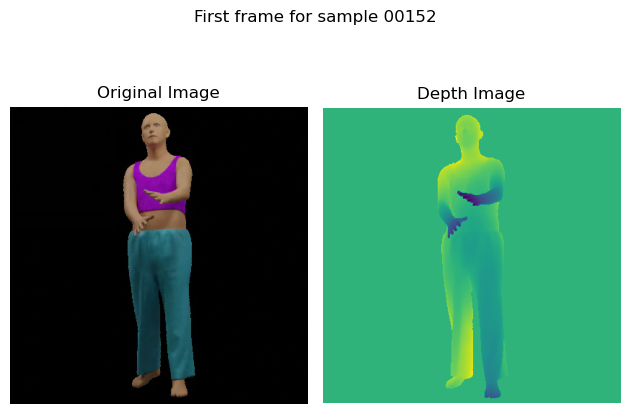

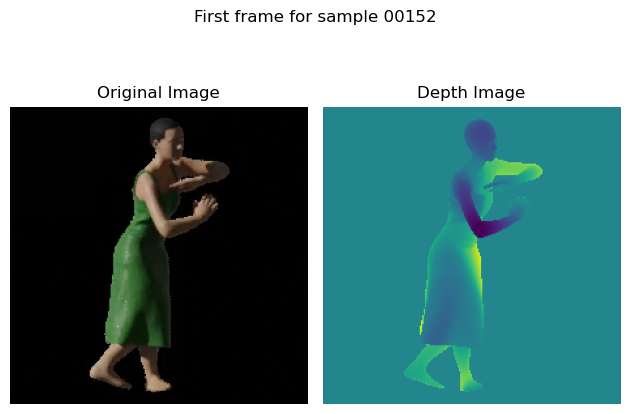

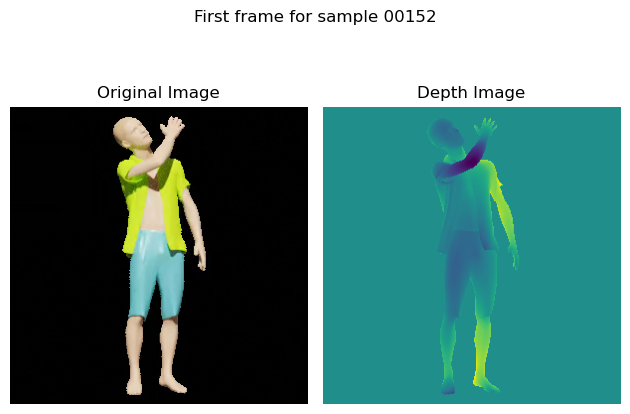

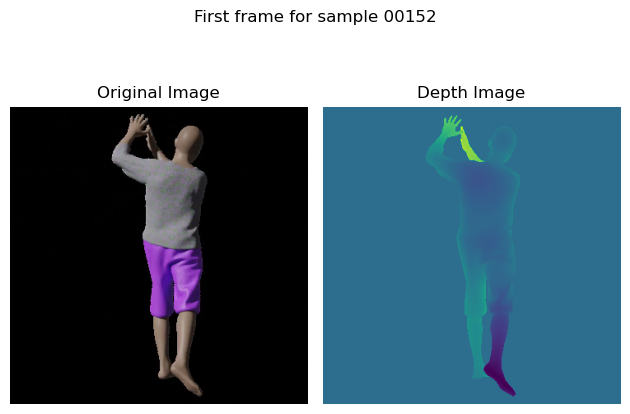

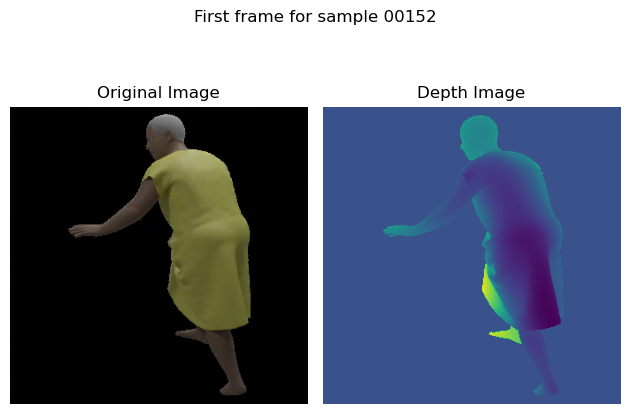

In [20]:
for cropped_img, cropped_depth in zip(cropped_imgs[5:10], cropped_depths[5:10]):

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(cropped_img)
    axs[0].set_title("Original Image")
    axs[1].imshow(cropped_depth)
    axs[1].set_title("Depth Image")
    # fig.text(0.5, 0.1, f"First frame for sample {sample}", ha='center')

    for ax in axs:
        ax.axis('off')

    fig.suptitle(f"First frame for sample {sample}")

    fig.tight_layout()
    plt.show()
    print('')